# Постановка задачи

Собран датасет из 17 тысяч статей с хабов на Habr. Для каждого наблюдения определена своя метка.

Стоит задача мультиклассовой классификации: обучения ML моделей классифицировать тему статьи, исходя из содержания.

# Осмотр данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("habr_dataset.csv")

df.head()

,id,title,content,hub
0,754792,Как Выигрывать в Игре Быки и Коровы (Метод Выб...,Существует старинная народная логическая игра....,maths
1,771854,Учим ЭЛТ-монитор играть музыку,Приветствую всех! \nЕсли вы хоть раз слышали п...,infosecurity
2,795113,Строим VXLAN/EVPN на несколько ЦОД,"Что делать и куда бежать, если тебе нужно пост...",it-infrastructure
3,802401,10. Особые линейные системы ч. 1,"Продолжаем публикацию лекций по предмету ""Упра...",maths
4,813461,Доплеровское Cмещение Несущей Спутников GPS,В этом тексте я намерен выяснить как быстро ме...,maths


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17235 entries, 0 to 17234
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       17235 non-null  int64 
 1   title    17235 non-null  object
 2   content  17235 non-null  object
 3   hub      17235 non-null  object
dtypes: int64(1), object(3)
memory usage: 538.7+ KB


Для каждой статьи есть следующие признаки:
1. `id` - идентификатор статьи на Habr.
2. `title` - название статьи.
3. `content` - содержание статьи.
4. `hub` - хаб статьи, **целевая переменная**.

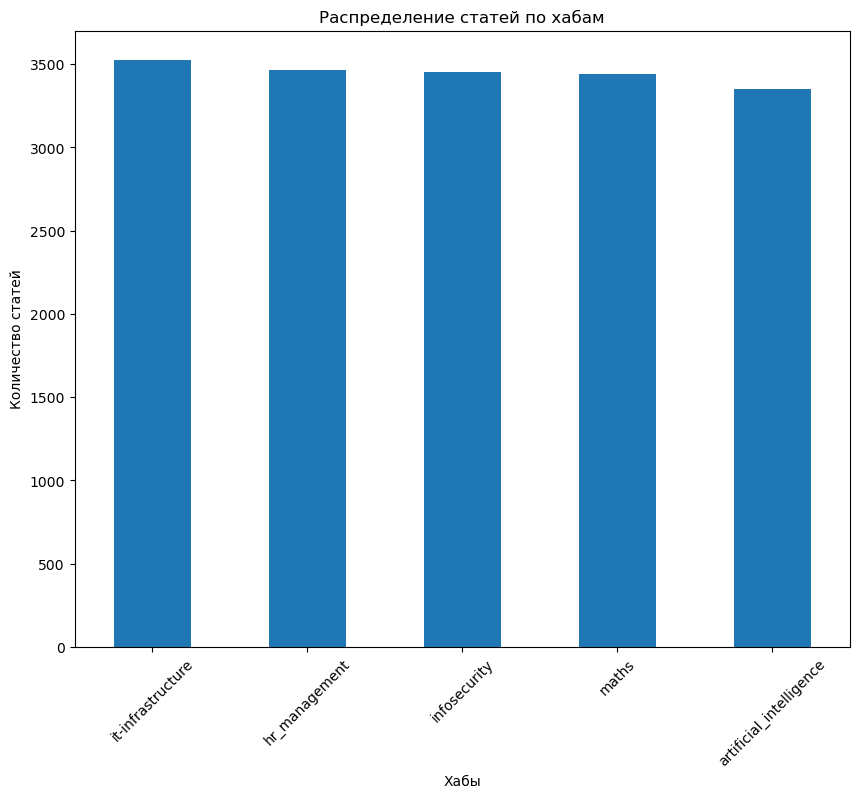

In [4]:
plt.figure(figsize=(10,8))

hub_counts = df["hub"].value_counts()

hub_counts.plot(kind="bar")

plt.title("Распределение статей по хабам")

plt.xlabel("Хабы")
plt.ylabel("Количество статей")

plt.xticks(rotation=45)

plt.show()

Статьи равномерно распределены по хабам, **нет дизбаланса классов**.

# Преобразование данных

В данном случае преобразование данных будет небольшим. Будут объединены `title` и `content`, т.к. они несут важную для классификации информацию. Также текст будет приведён к нижнему регистру.

In [4]:
def preprocess(text: str) -> str:
    """Выполняет преобработку текста

    Приводит текст к нижнему регистру.

    Args:
        text: текст для преобразования.

    Returns:
        str: преобразованный текст.
    """
    
    text = text.lower()

    return text

In [5]:
df["text"] = df["title"] + "\n\n" + df["content"]
df.drop(columns=["title", "content"], inplace=True)

In [6]:
df["text"] = df["text"].apply(preprocess)

In [7]:
df = df[["id", "text", "hub"]]

df.head()

,id,text,hub
0,754792,как выигрывать в игре быки и коровы (метод выб...,maths
1,771854,учим элт-монитор играть музыку\n\nприветствую ...,infosecurity
2,795113,строим vxlan/evpn на несколько цод\n\nчто дела...,it-infrastructure
3,802401,10. особые линейные системы ч. 1\n\nпродолжаем...,maths
4,813461,доплеровское cмещение несущей спутников gps\n\...,maths


# Выбор метрик

## Функция потерь

В силу отсутствия дизбаланса классов, для задачи мультиклассовой классификации подойдёт стандартная **категориальная кросс-энтропия**:

$$\mathcal{L}(x, y) = - \sum_{c=1}^{C} y_c \cdot \log (p_c),$$
где $y_c$ - OneHot-вектор класса, а $p_c$ - уверенность модели в классе $c$.

## Метрики

В качестве метрик выбраны **accuracy** (доля правильных ответов), **precision** (доля правильных предсказаний каждого класса), **recall** (доля найденных объектов каждого класса).

### Precision и Recall

Accuracy определяется для мультиклассовой классификации просто, поэтому стоит рассмотреть только precision и recall для лучшего понимания.

Для них используется One-vs-Rest подход.

Для каждого класса $c$ считается $\text{TP}_c, \text{FP}_c, \text{FN}_c$.
$$
\text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c},
\quad
\text{Recall}_с = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
$$

Каждый класс важен одинаково, поэтому будет использоваться macro-подход, то есть среднее арифметическое по классам:
$$
\text{Precision}_{\text{macro}} = \frac{1}{C} \sum_{c=1}^C \text{Precision}_c,
\quad
\text{Recall}_{\text{macro}} = \frac{1}{C} \sum_{c=1}^C \text{Recall}_c
$$

# Выбор модели

## Baseline

В качестве baseline-модели для тестирования и сравнения с более сложными выбрана **TF-IDF** и **логистическая регрессия**.

### TF-IDF

Нужен для векторизации текста. Состоит из двух компонентов:
1. *Term Frequency*- частота термина в документе
$$\text{tf}(t,d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t', d}},$$
   где $f_{t,d}$ - количество вхождение термина $t$ в документ $d$. Числитель здесь - общее количество терминов в документе.
2. *Inverse Document Frequency* - обратная частота термина. Показывает, насколько редким является термин во всей коллекции.
$$\text{idf}(t, D) = \log \bigg( \frac{|D|}{|\{ d \in D \mid t \in d \}|} \bigg),$$
   где $D$ - общее количество документов.

Тогда TF-IDF:
$$\text{tf-idf}(t, d, D) = \text{tf} (t,d) \cdot \text{idf} (t, D).$$

Получается, что IDF взвешивает редкие слова, давая им больший вес.

## RuBERT

В качестве более сложной модели выбран [RuBERT](https://huggingface.co/DeepPavlov/rubert-base-cased) от DeepPavlov, т.к. для русского текста она довольно популярна.

# Обучение моделей

## Подготовка данных

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
X = df["text"]
y = df["hub"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline

Для начала обучим baseline-модель.

In [43]:
vectorizer = TfidfVectorizer(
    max_features=10000, # размер словаря
    min_df=2, # отсекает слова, встречающиеся меньше 2 раз
    ngram_range=(1, 2) # использовать 1 и 2-граммы
)

In [44]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")

Train shape: (13788, 10000)
Test shape: (3447, 10000)


In [45]:
logistic_regression = LogisticRegression(
    max_iter=1000,
    random_state=42
)
logistic_regression = OneVsRestClassifier(logistic_regression)

`OneVsRestClassifier` - обёртка над `LogisticRegression`, которая использует несколько бинарных классификаторов: один для каждого класса.

In [46]:
logistic_regression.fit(X_train_tfidf, y_train)

,estimator,LogisticRegre...ndom_state=42)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42


In [47]:
y_pred = logistic_regression.predict(X_test_tfidf)
y_pred_proba = logistic_regression.predict_proba(X_test_tfidf)

In [48]:
accuracy  = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [49]:
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.851


In [50]:
print("Classification Report:")
print(report)

Classification Report:
                         precision    recall  f1-score   support

artificial_intelligence       0.86      0.86      0.86       690
          hr_management       0.89      0.94      0.91       679
           infosecurity       0.81      0.78      0.79       713
      it-infrastructure       0.82      0.76      0.79       697
                  maths       0.87      0.93      0.90       668

               accuracy                           0.85      3447
              macro avg       0.85      0.85      0.85      3447
           weighted avg       0.85      0.85      0.85      3447



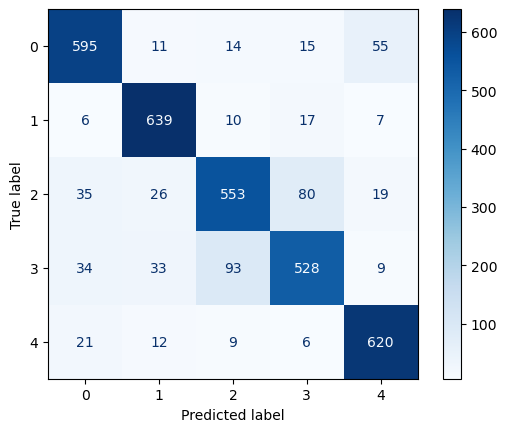

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")

Baseline-модель показала хорошие результаты. <br>
Она с достаточной точностью определяет каждый класс и, в целом, неплохо находит все объекты каждого класса.

Проверим веса и коэффициенты модели.

In [21]:
feature_names = vectorizer.get_feature_names_out()
classes = logistic_regression.classes_

In [22]:
import numpy as np

def top_words(class_index: int, top_n: int = 10):
    coefs = logistic_regression.estimators_[class_index].coef_[0]
    top_idx = np.argsort(coefs)[-top_n:]

    return [(feature_names[i], coefs[i]) for i in reversed(top_idx)]

In [23]:
classes_list = classes.tolist()

for idx in range(len(classes_list)):
    print(f"\nТоп слов для класса: {classes[idx]}:")
    for top_word in top_words(idx):
        print(f"\t{top_word[0]:20}: {top_word[1].item()}")


Топ слов для класса: artificial_intelligence:
	ии                  : 6.0144160909182505
	llm                 : 4.957578671264022
	ai                  : 3.6080661196197386
	нейросеть           : 3.308765093472513
	нейросети           : 2.963055324539667
	модели              : 2.8360882921193697
	chatgpt             : 2.7313712222936983
	модель              : 2.530017849746659
	openai              : 2.5167530569267815
	текст               : 2.4990548396220267

Топ слов для класса: hr_management:
	сотрудников         : 4.689192069247968
	hr                  : 4.048519626959115
	команды             : 3.5908877893219247
	не                  : 3.0829532407952347
	midpoint            : 2.9097245168462886
	вакансии            : 2.7434556836375794
	сотрудника          : 2.724971759170135
	компании            : 2.647300696281005
	человек             : 2.647121732846022
	работы              : 2.6155188239767426

Топ слов для класса: infosecurity:
	безопасности        : 5.75851579939098
	иб      

Модель правильно определелила слова для каждой из тем.

Объединим модели в `pipeline` и сохраним.

In [24]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("log_reg", logistic_regression)
])

In [25]:
#import joblib

# joblib.dump(pipeline, "tfidf_logreg_pipeline.pkl")

## RuBERT

Теперь обучим модель RuBERT от DeepPavlov.

In [9]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.preprocessing import LabelEncoder
import torch

MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [10]:
label_encoder = LabelEncoder()

X = df["text"]
y = label_encoder.fit_transform(df["hub"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=512
)
test_encodings = tokenizer(
    list(X_val),
    truncation=True,
    padding=True,
    max_length=512
)

In [12]:
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
num_labels

5

Напишем класс датасета для PyTorch.

In [52]:
class HabrDataset(torch.utils.data.Dataset):
    """Кастомный датасет из статей Habr

    Каждая статья имеет признаки:
        1. id - идентификатор
        2. text - текст и название статьи, приведённые к нижнем регистру.
        3. hub - метка, которую нужно предсказать.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])

        return item

In [14]:
train_dataset = HabrDataset(train_encodings, y_train)
test_dataset  = HabrDataset(test_encodings,  y_val)

Определим аргументы для обучения с помощью `TrainingArguments`. Также включим TensorBoard для мониторинга процесса.

In [25]:
%load_ext tensorboard
%tensorboard --logdir ./logs_2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33042), started 0:00:09 ago. (Use '!kill 33042' to kill it.)

In [22]:
num_epochs = 3
batch_size = 8

train_args = TrainingArguments(
    output_dir="./results_2",
    learning_rate=2e-5,
    max_grad_norm=1.0, # добавлено после обучения
    gradient_accumulation_steps=4, # добавлено после обучения
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_2",
    logging_steps=10,
    report_to="tensorboard"
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Приступим к обучению.

In [26]:
trainer.train()

/opt/anaconda3/envs/habr/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.445300,0.474344
2,0.452400,0.504436
3,0.162900,0.585918


/opt/anaconda3/envs/habr/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/habr/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/habr/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5172, training_loss=0.4373786845961146, metrics={'train_runtime': 11999.7553, 'train_samples_per_second': 3.447, 'train_steps_per_second': 0.431, 'total_flos': 1.0894143570579456e+16, 'train_loss': 0.4373786845961146, 'epoch': 3.0})

In [28]:
trainer.save_model("./finetuned_rubert2")
tokenizer.save_pretrained("./finetuned_rubert2")

('./finetuned_rubert2/tokenizer_config.json',
 './finetuned_rubert2/special_tokens_map.json',
 './finetuned_rubert2/vocab.txt',
 './finetuned_rubert2/added_tokens.json',
 './finetuned_rubert2/tokenizer.json')

Процесс обучения прошёл очень проблематично и нестабильно. Это будет обсуждено ниже. <br>
Значение Loss на валидационном датасете очень большое, однако стоит взглянуть на метрики, чтобы увидеть реальное качество модели.

Соберём метрики accuracy, precision, recall.

In [29]:
predictions = trainer.predict(test_dataset)

/opt/anaconda3/envs/habr/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [30]:
y_pred = predictions.predictions.argmax(axis=1)

In [31]:
y_true = test_dataset.labels

In [32]:
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, zero_division=0)

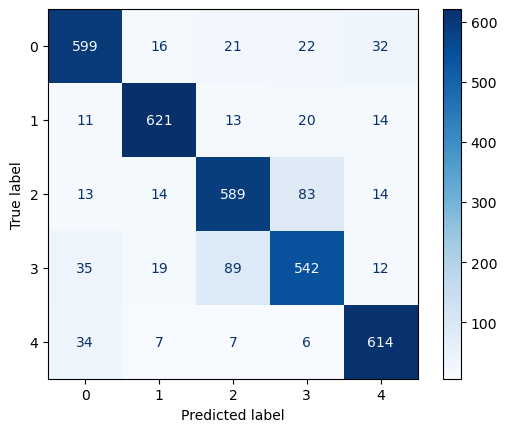

In [33]:
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")

In [34]:
print("Accuracy:", accuracy)

Accuracy: 0.8601682622570351


In [35]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       690
           1       0.92      0.91      0.92       679
           2       0.82      0.83      0.82       713
           3       0.81      0.78      0.79       697
           4       0.90      0.92      0.91       668

    accuracy                           0.86      3447
   macro avg       0.86      0.86      0.86      3447
weighted avg       0.86      0.86      0.86      3447



По метрикам видно, что модель хорошо определяет тематику статьи.

Она чуть точнее и находит больше объектов, чем baseline.

### Проблема при обучении

При обучении были видны явные проблемы. Взглянем на графики Loss-функции на тренировочном датасете и норму градиента на нём.



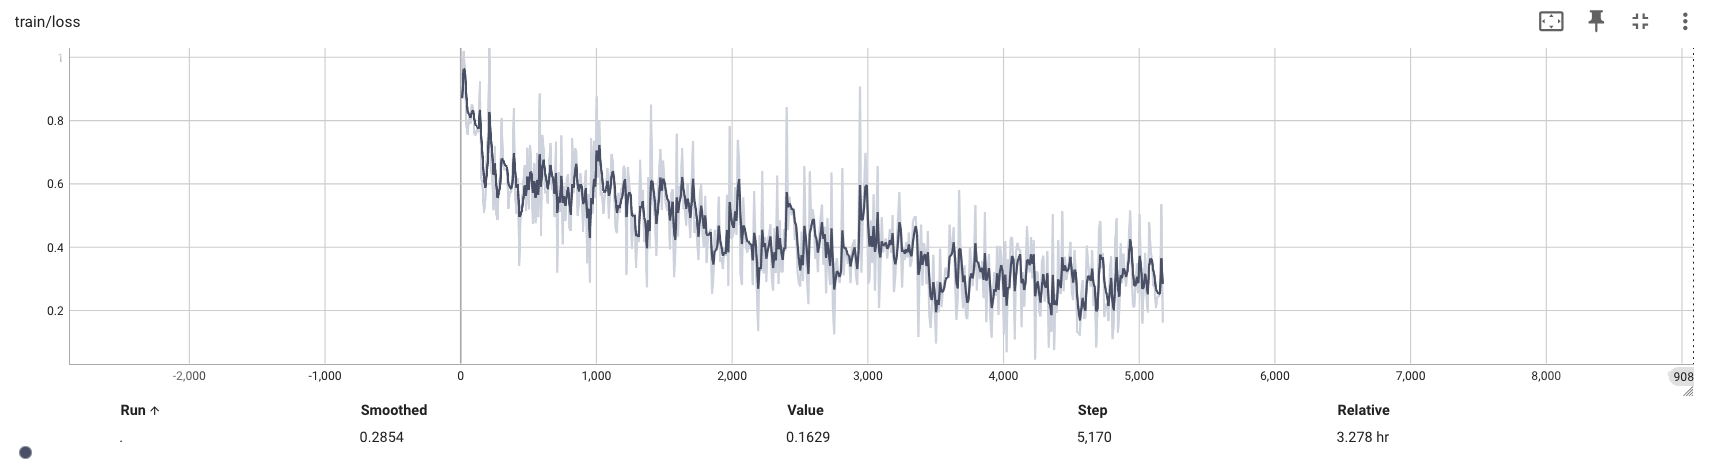

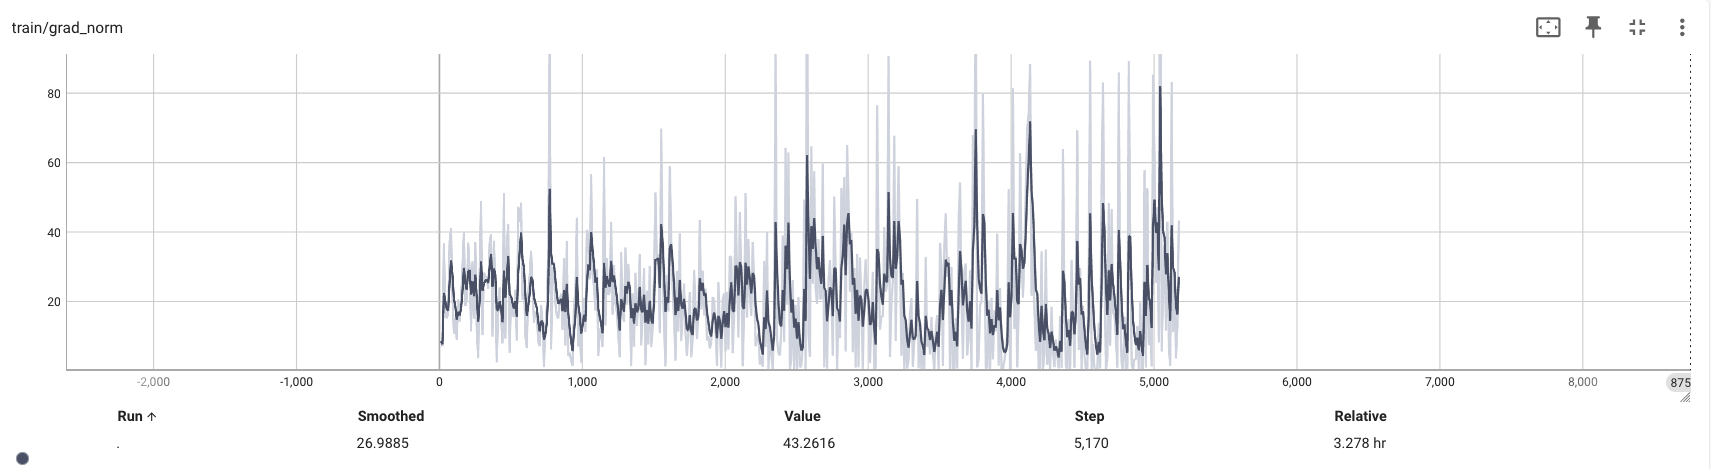

Видно, что графики нестабильны, они скачут.

Скорее всего, это происходит из-за шума в градиентах, т.к. его норма постоянно скачет и очень сильно.<br>
В следующий раз лучше использовать Gradient Clipping, выбрав в `TrainingArguments` параметр `max_grad_norm`.

# Сравнение моделей

Итак, были обучены модели:
1. TF-IDF + Logistic Regression в качестве baseline.
2. RuBERT от DeepPavlov.

Стоит сравнить их, чтобы понять, какую выгоднее использовать в реальной разработке.

| Модель | Accuracy | Precision (Macro) | Recall (Macro) |
| --- | --- | --- | --- |
| Baseline | 0.85 | 0.85 | 0.85 |
| RuBERT | 0.86 | 0.86 | 0.86 |

Можно видеть, что модели показывают очень близкие результаты. RuBERT лишь немного опережает baseline, притом, что он обучался около 3 часов (стоит учесть, что это без использования GPU).

Скорее всего, при наличии Gradient Clipping, RuBERT бы показал себя намного лучше, однако в данном случае baseline показывает достаточную точность, что в соотношении качество/вычислительные затраты делает его **более выгодным**.

# Итог

Были обучены модели машинного обучения на собранных данных. Обе показали себя хорошо, однак в сравнении выиграла baseline модель.